# Q-learning 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
rng = np.random.default_rng()
import time

from IPython.display import clear_output

try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    !pip install gym > /dev/null 2>&1
    
import gym

def running_average(x, N):
    cumsum = np.cumsum(np.insert(np.array(x), 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N

In this short exercise, we are going to apply **Q-learning** on the Taxi environment used last time for MC control.

As a reminder, Q-learning updates the Q-value of a state-action pair **after each transition**, using the update rule:

$$\Delta Q(s_t, a_t) = \alpha \, (r_{t+1} + \gamma \, \max_{a'} \, Q(s_{t+1}, a') - Q(s_t, a_t))$$

**Q:** Update the class you designed for online MC in the last exercise so that it implements Q-learning. 

The main difference is that the `update()` method has to be called after each step of the episode, not at the end. It simplifies a lot the code too (no need to iterate backwards on the episode).

You can use the following parameters at the beginning, but feel free to change them:

* Discount factor $\gamma = 0.9$. 
* Learning rate $\alpha = 0.1$.
* Epsilon-greedy action selection, with an initial exploration parameter of 1.0 and an exponential decay of $10^{-5}$ after each update (i.e. every step!).
* A total number of episodes of 20000.

Keep the general structure of the class: `train()` for the main loop, `test()` to run one episode without exploration, etc. Add a method to compute the discounted return of each episode, as it will not be done automatically by the `update()` method anymore. Plot the training and test performance in the end and render the learned deterministic policy for 10 episodes.

*Note:* if $s_{t+1}$ is terminal (`done` is true after the transition), the target should not be $r_{t+1} + \gamma \, \max_{a'} \, Q(s_{t+1}, a')$, but simply $r_{t+1}$ as there is no next action.

In [2]:
class QLearningAgent:
    """
    Q-learning agent.
    """
    
    def __init__(self, env, gamma, epsilon, decay_epsilon, alpha):
        """
        :param env: gym-like environment
        :param gamma: discount factor
        :param epsilon: exploration parameter
        :param decay_epsilon: exploration decay parameter
        :param alpha: learning rate
        """
        self.env = env
        self.gamma = gamma
        self.epsilon = epsilon
        self.decay_epsilon = decay_epsilon
        self.alpha = alpha
        
        # Q_table
        self.Q = np.zeros([self.env.observation_space.n, self.env.action_space.n])
    
    def act(self, state):
        "Returns an action using epsilon-greedy action selection."
        
        action = rng.choice(np.where(self.Q[state, :] == self.Q[state, :].max())[0])
        
        if rng.random() < self.epsilon:
            action = self.env.action_space.sample() 
        
        return action
    
    def update(self, state, action, reward, next_state, done):
        "Updates the agent using a single transition."
        
        # Bellman target
        target = reward
        
        if not done:
            target += self.gamma * self.Q[next_state, :].max()
        
        # Update the Q-value
        self.Q[state, action] += self.alpha * (target - self.Q[state, action])
            
        # Decay epsilon
        self.epsilon = self.epsilon * (1 - self.decay_epsilon)
            
    
    def train(self, nb_episodes, render=False):
        "Runs the agent on the environment for nb_episodes. Returns the list of obtained returns."

        # Returns
        returns = []

        # Fixed number of episodes
        for episode in range(nb_episodes):

            # Reset
            state = self.env.reset()
            done = False
            nb_steps = 0

            # Store rewards
            rewards = []

            # Sample the episode
            while not done:
                
                # Render the current state
                if render:
                    clear_output(wait=True)
                    self.env.render()
                    time.sleep(0.1)

                # Select an action 
                action = self.act(state)

                # Perform the action
                next_state, reward, done, info = self.env.step(action)
                
                # Append reward
                rewards.append(reward)

                # Learn from the transition
                self.update(state, action, reward, next_state, done)

                # Go in the next state
                state = next_state

                # Increment time
                nb_steps += 1

            # Compute the discounted return of the episode.
            return_episode = self.discounted_return(rewards)    

            # Store info
            returns.append(return_episode)
            
            # Print info
            if episode % 100 == 0:
                clear_output(wait=True)
                print('Episode', episode, ':')
                print(' return:', return_episode)
                print(' steps:', nb_steps)
                print(' epsilon:', self.epsilon)
            
        return returns
    
    def test(self, render=True):
        "Performs a test episode without exploration."
        previous_epsilon = self.epsilon
        self.epsilon = 0.0
        
        # Reset
        state = self.env.reset()
        done = False
        nb_steps = 0
        rewards= 0

        # Sample the episode
        while not done:
            if render:
                clear_output(wait=True)
                self.env.render()
                time.sleep(0.1)
            action = self.act(state)
            next_state, reward, done, info = self.env.step(action)
            rewards += reward
            state = next_state
            nb_steps += 1
            
        self.epsilon = previous_epsilon
            
        return rewards, nb_steps
    
    def discounted_return(self, rewards):
        "Computes the discounted return of an episode based on the list of rewards."
        ret = 0.0
        for reward in reversed(rewards):
            ret = reward + self.gamma*ret
        return ret

Episode 19900 :
 return: 5.9432300000000025
 steps: 7
 epsilon: 0.0190286448954996


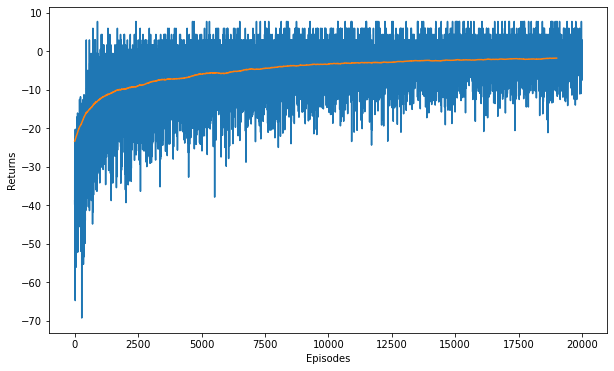

Test performance 7.787


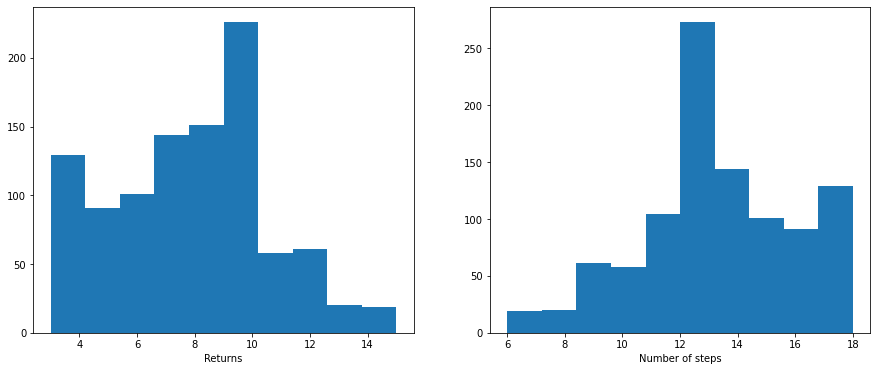

In [3]:
# Parameters
gamma = 0.9
epsilon = 1.0
decay_epsilon = 1e-5
alpha = 0.1
nb_episodes = 20000

# Create the environment
env = gym.make("Taxi-v3")

# Create the agent
agent = QLearningAgent(env, gamma, epsilon, decay_epsilon, alpha)

# Train the agent 
returns = agent.train(nb_episodes)

# Plot training returns
plt.figure(figsize=(10, 6))
plt.plot(returns)
plt.plot(running_average(returns, 1000))
plt.xlabel("Episodes")
plt.ylabel("Returns")
plt.show()

# Test the agent for 1000 episodes
test_returns = []
test_steps = []
for episode in range(1000):
    return_episode, nb_steps = agent.test(render=False)
    test_returns.append(return_episode)
    test_steps.append(nb_steps)
print("Test performance", np.mean(test_returns))

plt.figure(figsize=(15, 6))
plt.subplot(121)
plt.hist(test_returns)
plt.xlabel("Returns")
plt.subplot(122)
plt.hist(test_steps)
plt.xlabel("Number of steps")
plt.show()

In [4]:
# Visualize some episodes
returns = []
length_episode = []

for episode in range(5):
    
    # Perform one episode
    return_episode, nb_steps = agent.test(render=True)
    
    # Store info
    returns.append(return_episode)
    length_episode.append(nb_steps)


print("Returns:", returns)
print("Number of steps", length_episode)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
Returns: [6, 8, 9, 9, 12]
Number of steps [15, 13, 12, 12, 9]


**Q:** Compare the performance of Q-learning to online MC. Experiment with parameters (gamma, epsilon, alpha, etc.).

Episode 19900 :
 return: 4.0
 steps: 17
 epsilon: 0.012511064005448906


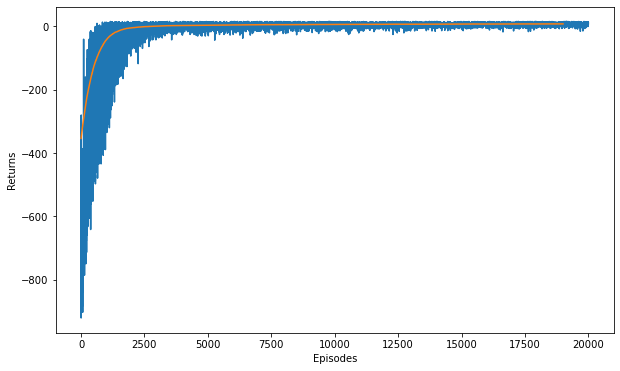

Test performance 7.962


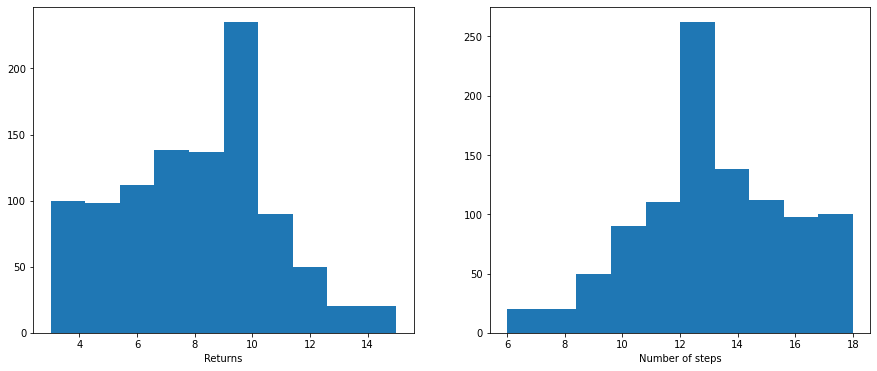

In [5]:
# Parameters
gamma = 1.0
epsilon = 1.0
decay_epsilon = 1e-5
alpha = 0.05
nb_episodes = 20000

# Create the environment
env = gym.make("Taxi-v3")

# Create the agent
agent = QLearningAgent(env, gamma, epsilon, decay_epsilon, alpha)

# Train the agent 
returns = agent.train(nb_episodes)

# Plot training returns
plt.figure(figsize=(10, 6))
plt.plot(returns)
plt.plot(running_average(returns, 1000))
plt.xlabel("Episodes")
plt.ylabel("Returns")
plt.show()

# Test the agent for 1000 episodes
test_returns = []
test_steps = []
for episode in range(1000):
    return_episode, nb_steps = agent.test(render=False)
    test_returns.append(return_episode)
    test_steps.append(nb_steps)
print("Test performance", np.mean(test_returns))

plt.figure(figsize=(15, 6))
plt.subplot(121)
plt.hist(test_returns)
plt.xlabel("Returns")
plt.subplot(122)
plt.hist(test_steps)
plt.xlabel("Number of steps")
plt.show()

In [6]:
# Visualize some episodes
returns = []
length_episode = []

for episode in range(5):
    
    # Perform one episode
    return_episode, nb_steps = agent.test(render=True)
    
    # Store info
    returns.append(return_episode)
    length_episode.append(nb_steps)


print("Returns:", returns)
print("Number of steps", length_episode)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
Returns: [6, 12, 4, 8, 5]
Number of steps [15, 9, 17, 13, 16]


**A:** Q-learning accepts much higher values of gamma than MC, because the returns have a much lower variance. With the right parameters, Q-learning can learn much faster than MC.